# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture is provided in ``` resnet.py ```. Then you are going to immplement targeted and untargeted FGSM attack and also $l_{∞}$-PGD attack, and evaluate the performance of the trained model on the adversarial data.


**Attention!** Make sure you do not miss the questions asked at the end of the notebook.






Name: Mohammad Hossein Sameti

Student ID: 401204932

#**Setups**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#feel free to change the path if needed

!cd '/content/drive/MyDrive/DL_HW5'

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
'''
These are the default values for variables, these should work, but if needed, you are allowed to change these parameters.
'''

batch_size = 128
lr = 1e-3
epochs = 100

#**Data Preparation (5 pts)**
Use cifar10 dataset provided in torchvision and create train and test dataloaders according to the given transformations.

In [4]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


###################################################
#prepare training and test datasets and loaders   #
###################################################



######################
# Your code goes here
from torch.utils.data import DataLoader
TRAIN_DATASET = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
TEST_DATASET = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(
    TRAIN_DATASET,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    TEST_DATASET,
    batch_size=batch_size,
    )


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


#**Building The Model**

In [9]:
########################################
#build your model                      #
########################################
print('==> Building model..')
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

==> Building model..


#**Training and Evaluating The Model (5 pts)**

In [5]:
# Training
def train(epoch, net, optimizer, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), 100*correct/total


def test(epoch, net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(testloader), 100 * correct / total

In [10]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

######################
# Your code goes here

train_loss= []
test_loss= []
train_acc = []
test_acc = []
for epoch in range(5):
    train_l, train_a = train(epoch, net, optimizer, train_loader)
    test_l, test_a = test(epoch, net, test_loader)
    train_loss.append(train_l)
    train_acc.append(train_a)
    test_loss.append(test_l)
    test_acc.append(test_a)



Epoch: 0

Epoch: 1

Epoch: 2

Epoch: 3

Epoch: 4


In [11]:
########################################
#save your model and history           #
########################################


######################
# Your code goes here

torch.save(net.state_dict(), '/content/drive/MyDrive/DL_HW5/model.torch')

##**Train and Test Loss and Accuracy Plots**

Text(0.5, 1.0, 'test accuracy')

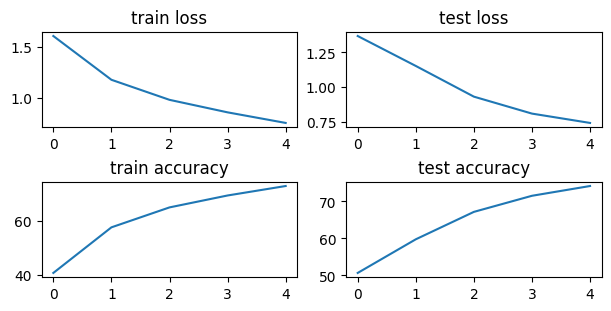

In [12]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################
fig, ax = plt.subplots(2,2, figsize=(6,3), layout="constrained")
ax[0,0].plot(train_loss)
ax[0,0].set_title('train loss')
ax[0,1].plot(test_loss)
ax[0,1].set_title('test loss')
ax[1,0].plot(train_acc)
ax[1,0].set_title('train accuracy')
ax[1,1].plot(test_acc)
ax[1,1].set_title('test accuracy')

######################
# Your code goes here

#**FGSM Attack (45 pts)**
In this section you must implement targeted and untargeted FGSM attack and evalute the trained model performance on the adversarial data.[link text](https://)

##**Untargeted FGSM Attack**

In [13]:
########################################
#define untargeted FGSM attack         #
########################################

def FGSM (model, x, y, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  delta = None
  ######################
  # Your code goes here
  loss = torch.nn.CrossEntropyLoss()
  xin = x.data
  xin.requires_grad = True
  y_hat = model(xin)
  cost = loss(y_hat, y)
  model.zero_grad()
  cost.backward()
  delta = epsilon * xin.grad.detach().sign()


  return x+delta, delta, model(x+delta)

###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [14]:
######################
# Your code goes here
epsilon = [1/255, 4/255, 8/255]
criterion = nn.CrossEntropyLoss()

for eps in epsilon:
  correct = 0
  total = 0
  for (inputs, targets) in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    fgsm_outputs = FGSM(net, inputs, targets, eps)[2]
    _, predicted = fgsm_outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  print(f'epsilon = {eps} accuracy = {100 * correct / total}')

epsilon = 0.00392156862745098 accuracy = 69.17
epsilon = 0.01568627450980392 accuracy = 54.44
epsilon = 0.03137254901960784 accuracy = 37.74


###**FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [15]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: intial clipping threshold for FGSM

  outputs:
    epsilon: the epsilon that flips the label.
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """



  ######################
  # Your code goes here
  while True:
    x_adv, delta, y_adv = FGSM(model, x.unsqueeze(0), label, initial_epsilon)

    _, FGSM_OUT = y_adv.max(1)
    if FGSM_OUT == label:
      initial_epsilon += 1/255
    else:
      break

  return initial_epsilon, delta, y_adv


### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

a
Label = 0


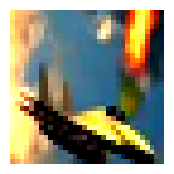

Label = 1


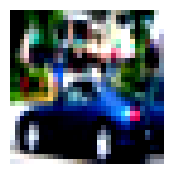

Label = 2


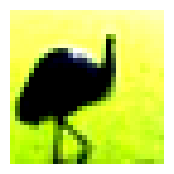

Label = 3


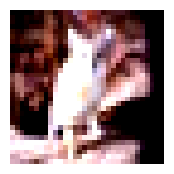

Label = 4


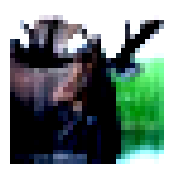

Label = 5


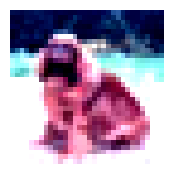

Label = 6


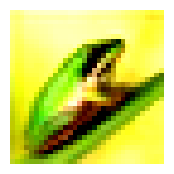

Label = 7


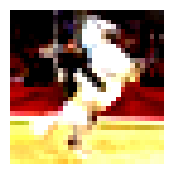

Label = 8


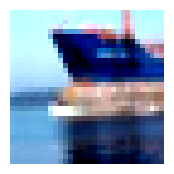

Label = 9


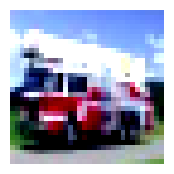

In [6]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################

def imshow(img, s):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(s,s))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()





#######################
# Your code goes here
batch_x, batch_y = next(iter(test_loader))
image_index = np.zeros(10)
print('a')
for i, j in enumerate(batch_y):
  image_index[j] = int(i)
images = []
for j, i in enumerate(image_index):
  print(f'Label = {j}')

  imshow(batch_x[int(i)], 2)



Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/comm.py:231: UserWarning: Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".
  warnings.warn(


True Label is 0 But model predict 1


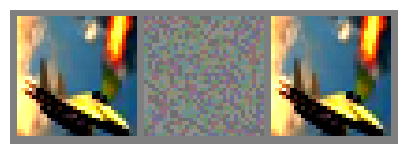

True Label is 1 But model predict 9


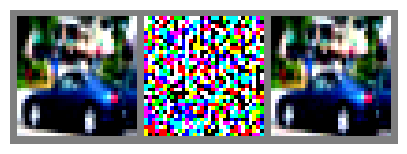

True Label is 2 But model predict 5


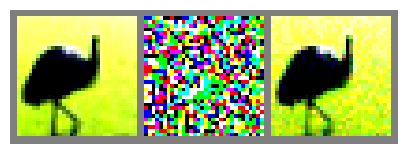

True Label is 3 But model predict 5


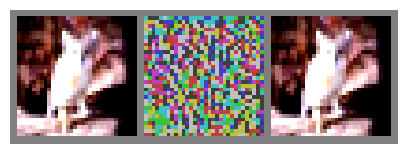

True Label is 4 But model predict 7


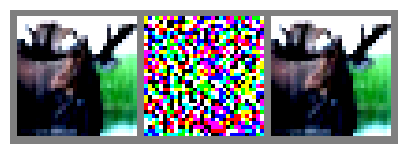

True Label is 5 But model predict 4


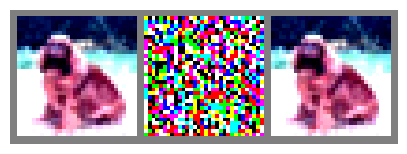

True Label is 6 But model predict 2


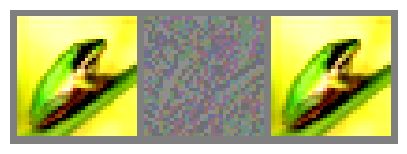

True Label is 7 But model predict 5


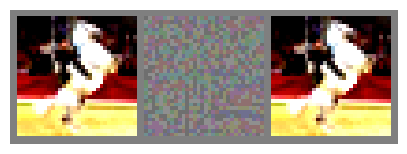

True Label is 8 But model predict 2


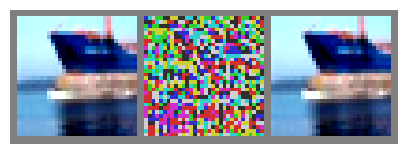

True Label is 9 But model predict 1


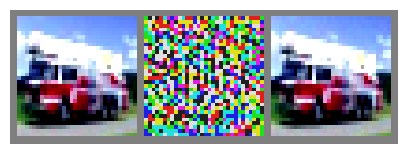

In [16]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################




######################
# Your code goes here
for i, j in enumerate(image_index):
  epsilon, delta, y_adv = generate_adversarial_FGSM(net, batch_x[int(j)], torch.Tensor([i]).type(torch.LongTensor).to(device), initial_epsilon=1/255)
  print(f"True Label is {i} But model predict {y_adv.max(1)[1].item()}")
  #imshow((1/epsilon) * delta)
  with torch.no_grad():
    true_image = batch_x[int(j)]
    magnified_perturbation = (1/eps) * delta.squeeze(0)
    perturbed_image = (batch_x[int(j)]+delta).squeeze(0)

    imshow(torchvision.utils.make_grid(torch.stack([true_image, magnified_perturbation, perturbed_image])), 5)

##**Targeted FGSM Attack**
implement targeted FGSM attack.

In [17]:
########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    y_targ = target label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
  """

  delta = None

  ######################
  # Your code goes here
  loss = torch.nn.CrossEntropyLoss()
  xin = x.data
  xin.requires_grad = True
  y_hat = model(xin)
  cost = loss(y_hat, y) - loss(y_hat, y_targ)
  model.zero_grad()
  cost.backward()
  delta = epsilon * xin.grad.detach().sign()


  return x+delta, delta, model(x+delta)

###**Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [18]:
######################
# Your code goes here
epsilon = [1/255, 4/255, 8/255]
criterion = nn.CrossEntropyLoss()
acc_most = []
for eps in epsilon:
  correct = 0
  total = 0
  for (inputs, targets) in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    t = net(inputs)
    for i in range(t.shape[0]):
      t[i, targets[i]] = -99999
    t = t.max(1)[1]
    fgsm_outputs = FGSM_targeted(net, inputs, targets, t, eps)[2]
    _, predicted = fgsm_outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  acc_most.append(100 * correct / total)
  print(f'epsilon = {eps} accuracy = {100 * correct / total}')

epsilon = 0.00392156862745098 accuracy = 68.96
epsilon = 0.01568627450980392 accuracy = 53.47
epsilon = 0.03137254901960784 accuracy = 36.39


for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [19]:
######################
# Your code goes here
epsilon = [1/255, 4/255, 8/255]
criterion = nn.CrossEntropyLoss()
acc_least = []
for eps in epsilon:
  correct = 0
  total = 0
  for (inputs, targets) in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    t = net(inputs)
    for i in range(t.shape[0]):
      t[i, targets[i]] = 99999
    t = t.min(1)[1]
    fgsm_outputs = FGSM_targeted(net, inputs, targets, t, eps)[2]
    _, predicted = fgsm_outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()
  acc_least.append(100 * correct / total)
  print(f'epsilon = {eps} accuracy = {100 * correct / total}')

epsilon = 0.00392156862745098 accuracy = 71.51
epsilon = 0.01568627450980392 accuracy = 63.53
epsilon = 0.03137254901960784 accuracy = 52.7


plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

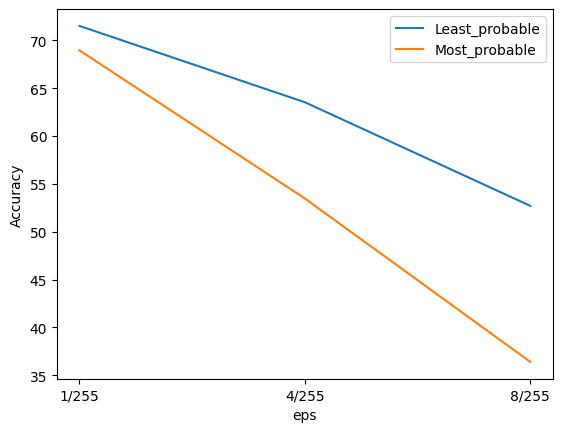

In [20]:
######################
# Your code goes here
plt.plot(np.array(['1/255', '4/255', '8/255']), acc_least, label='Least_probable')
plt.plot(np.array(['1/255', '4/255', '8/255']), acc_most, label='Most_probable')
plt.xlabel('eps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#**PGD Attack (30 pts)**

Implement PGD attack in the following cell. There is no need to change the default $\epsilon$ and $\alpha$.

In [21]:
def PGD (model, x, y, iterations, epsilon=8/255, alpha=3/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    iterations: number of iterations for PGD attack
    epsilon: clipping threshold for PGD
    alpha: step size for PGD attack

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """

  delta = None

  ######################
  # Your code goes here
  loss = criterion=nn.CrossEntropyLoss()
  xin = x.data

  for iter in range(iterations):
    x.requires_grad = True
    y_hat = model(x)
    cost = loss(y_hat, y)
    model.zero_grad()
    cost.backward()
    delta = alpha * x.grad.detach().sign()
    x_adv = x + delta
    x = (x + torch.clamp(x_adv - xin , min=-epsilon, max=epsilon)).detach()
  delta = x - xin

  return xin+delta, delta, model(xin + delta)

##**Evaluation**
for iterations $\in \{3, 7, 12\}$, evaluate performance of the model on adversarial test data.

In [22]:
######################
# Your code goes here

iterations = [3, 7, 12]
for iter in iterations:
  correct = 0
  total = 0
  for (inputs, targets) in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    pgd_outputs = PGD(net, inputs, targets, iter)[2]
    _, predicted = pgd_outputs.max(1)
    total += targets.size(0)
    correct += predicted.eq(targets).sum().item()

  print(f'iteration = {iter} accuracy = {100 * correct / total}')

iteration = 3 accuracy = 13.75
iteration = 7 accuracy = 0.75
iteration = 12 accuracy = 0.43


#**Questions (15 pts)**

1. What was the effect of $\epsilon$ in targeted and untargeted FGSM attack according to your observations?

با توجه به نتایج بدست آمده با افزایش مقدار اپسیلون دقت مدل کاهش میابد و تغییرات مقادیر پیکسل های تصاویر بیشتر عوض میشوند.

2. Compare performance of the model on the least probable and most probable targetted FGSM attacks, justify your observation.
با نگاه به نتایج بدست آمده اگر کلاس هدف دارای بیشترین احتمال باشد مدل راحت تر حمله میخورد و دقت مدل نسبت به وقتی که کلاس هدف برابر کلاس با کمترین احتمال است، بیشتر کاهش میابد. (کاملا منطقی :))
3. What was the effect of number of iterations in PGD attack according to your observations?
با افزایش تعداد مراحل، دقت مدل بیشتر کاهش میابد.
4. compare the performance of model on PGD attacks and FGSM attacks.
با توجه به نتایج بدست امده حمله پی‌جی‌دی موفق تر از  اف‌جی‌اس‌ام است و بیشتر میتواند دقت مدل روی مجموعه دادگان را کاهش دهد.